In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, backend as K


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

from scikeras.wrappers import KerasClassifier

from keras_tuner.tuners import RandomSearch 

NumPy: 1.24.4
SciPy: 1.10.1
Scikit-learn: 1.2.2


# Load datasets

In [37]:
df_train_ekman = pd.read_csv('data/ekman_train.csv')
df_val_ekman = pd.read_csv('data/ekman_val.csv')
df_test_ekman = pd.read_csv('data/ekman_test.csv')

# Extract text and labels from the datasets

In [ ]:
# Extract text and labels from the dataset
train_texts = df_train_ekman['text'].tolist()
train_labels = df_train_ekman[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].values.tolist()

# Extract text and labels from the validation dataset
val_texts = df_val_ekman['text'].tolist()
val_labels = df_val_ekman[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].values.tolist()

# Extract text and labels from the test dataset
test_texts = df_test_ekman['text'].tolist()
test_labels = df_test_ekman[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].values.tolist()

# Tokenize and pad sequences for the training, validation and test set

In [ ]:
# Initialize the tokenizer for converting text into sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
sequences_train = tokenizer.texts_to_sequences(train_texts)
max_sequence_length_train = max([len(seq) for seq in sequences_train])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length_train)

sequences_val = tokenizer.texts_to_sequences(val_texts)
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_sequence_length_train)  

sequences_test = tokenizer.texts_to_sequences(test_texts)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length_train)  

# Convert output data to numpy arrays

In [ ]:
X_train = np.array(padded_sequences_train)
y_train = np.array(train_labels)

X_val = np.array(padded_sequences_val)
y_val = np.array(val_labels)

X_test = np.array(padded_sequences_test)
y_test = np.array(test_labels)

# Build model and hyperparameter tuning process

In [ ]:
def build_model(hp):
    # Initialize a sequential neural network model
    model = Sequential()

    # Add an embedding layer to transform word indices into dense vectors
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32))

    # Add an LSTM layer to capture temporal dependencies in text
    model.add(LSTM(64))

    # Add dropout to prevent overfitting
    model.add(Dropout(0.3))

    # Tune the number of hidden layers
    hp_hidden_layers = hp.Int('hidden_layers', min_value=1, max_value=3, step=1)
    for _ in range(hp_hidden_layers):
        # For each hidden layer, tune the number of units
        hp_units = hp.Int(f'units_{_}', min_value=32, max_value=128, step=32)
        model.add(Dense(units=hp_units, activation='relu'))
        # Dropout for regularization
        model.add(Dropout(0.5))

    # Output layer: 7 neurons for 7 emotions, using sigmoid for multilabel classification
    model.add(Dense(7, activation='sigmoid'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Hyperparameter tuning using Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='emotion_hyperparameter_tuning'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping])


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/emotion_classification_hyperparameter_tuning/tuner0.json


# Printing the best hyperparameters

In [40]:
print("Best Hyperparameters:")
print(f"- Hidden Layers: {best_hps.get('hidden_layers')}")
for i in range(best_hps.get('hidden_layers')):
    print(f"  - Units in Hidden Layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
- Hidden Layers: 1
  - Units in Hidden Layer 1: 320
- Learning Rate: 0.001


# Predict probabilities for the test set and convert probabilities to binary predictions

In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping])

y_pred_prob = best_model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

Epoch 1/5
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.3830 - loss: 0.3898 - val_accuracy: 0.4979 - val_loss: 0.3197
Epoch 2/5
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.5434 - loss: 0.3051 - val_accuracy: 0.5207 - val_loss: 0.3129
Epoch 3/5
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6213 - loss: 0.2656 - val_accuracy: 0.5142 - val_loss: 0.3208
Epoch 4/5
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6943 - loss: 0.2244 - val_accuracy: 0.5037 - val_loss: 0.3552
Epoch 5/5
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.7492 - loss: 0.1873 - val_accuracy: 0.4927 - val_loss: 0.3810
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


# Visulization of plot figure of training and validation Loss

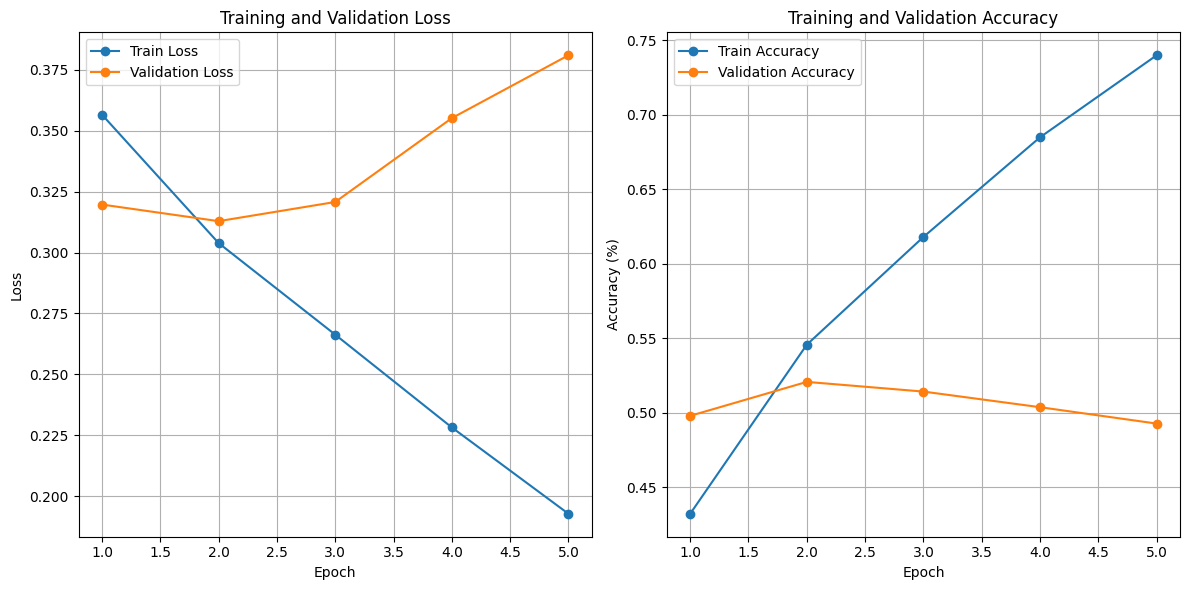

In [ ]:
def plot_training_history(history):
    
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history_dict["val_accuracy"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Generate classification report

In [ ]:
report = classification_report(y_test, y_pred, target_names=['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
accuracy = accuracy_score(y_test, y_pred)
print(report)
print(f"Accuracy: {accuracy:.4f}")

              precision    recall  f1-score   support

       anger       0.53      0.07      0.12      1588
     disgust       0.00      0.00      0.00       258
        fear       0.00      0.00      0.00       254
         joy       0.77      0.64      0.70      4728
     neutral       0.49      0.33      0.40      3144
     sadness       0.68      0.18      0.28      1010
    surprise       0.00      0.00      0.00      1608

   micro avg       0.67      0.35      0.46     12590
   macro avg       0.35      0.17      0.21     12590
weighted avg       0.53      0.35      0.40     12590
 samples avg       0.38      0.36      0.36     12590

Accuracy: 0.3416


/Users/marcuskrarup/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcuskrarup/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
